# Computer Problem Set 2.1
## The Black-Scholes hedging strategy

### Question 1

In order to simulate the discrete path, we first create the path $W_t$, then use the broadcasting method to find $S_t$.

In [1]:
import numpy as np
import scipy.stats

In [2]:
# Preambule
T = 1.5
S_0 = 100
sigma = 0.3
r = 0.05
N = 1000

In [3]:
def s_samples(n, mu):
    # We first take the brownian motion W_t :
    DeltaT = T / n
    W_t = np.random.normal(loc=0, scale=np.sqrt(DeltaT), size=(N, n + 1))
    W_t[:, 0] = 0.
    W_t = np.cumsum(W_t, axis=1)
    
    # S_t : without the term exp((mu - sigma^2 / 2) * t)
    S_t = S_0 * np.exp(sigma * W_t)
    S_t *= np.exp((mu - sigma ** 2 / 2) * np.linspace(0, T, n + 1))
    return S_t

We fixe n = 500 in this question.

In [4]:
n = 500
for mu in [0.05, 0.02, 0.45]:
    sample = s_samples(n, mu)
    mean_ = np.mean(sample[:, -1])
    var_ = np.var(sample[:, -1])
    half_IC = 1.96 * np.sqrt(var_/1000)
    
    print("For mu = {}, mean = {} \tand var = {}".format(mu, mean_, var_))
    print("Expectation is in [{}, {}] with 95% confidence".format(mean_-half_IC, mean_+half_IC))

For mu = 0.05, mean = 107.83416596328088 	and var = 1688.0878603682077
Expectation is in [105.28760783035116, 110.3807240962106] with 95% confidence
For mu = 0.02, mean = 103.27176837243233 	and var = 1552.6207318021575
Expectation is in [100.82952600049396, 105.71401074437071] with 95% confidence
For mu = 0.45, mean = 197.8083468465244 	and var = 5585.401434373064
Expectation is in [193.17618988132043, 202.44050381172835] with 95% confidence


Since $S_T = S_0e^{(\mu - \frac{\sigma^2}{2})T+\sigma W_T}$, we have $\mathbb{E}[S_T] = S_0 e^{\mu T}$ and $Var[S_T]= S_0^2e^{2\mu T + \sigma^2 T} - S_0^2e^{2\mu T}$ because $W_T \sim \mathcal{N}(0, T)$.

In [5]:
for mu in [0.05, 0.02, 0.45]:
    mean_ = S_0 * np.exp(mu*T)
    var_ = S_0 * S_0 * np.exp(2 * mu * T + sigma * sigma * T) - mean_ ** 2
    print("For mu = {}, mean = {} \tand var = {}".format(mu, mean_, var_))

For mu = 0.05, mean = 107.78841508846315 	and var = 1679.277853931906
For mu = 0.02, mean = 103.0454533953517 	and var = 1534.744399443709
For mu = 0.45, mean = 196.40329759698474 	and var = 5575.39882081603


The drift parameter $\mu$ design the "drift" in expectation of the $S_T$ at the end. More the drift is, more the expectation is far from the $S_0$ at $T$.

### Question 2

#### (a)

In [6]:
# The cumulative function N
def Norm(x):
    return scipy.stats.norm.cdf(x)

def d(sign, s, k, v):
    '''
    sign : d+ or d-. if sign takes value in {-1, 1}
    s, k, v : the variables for d
    '''
    return np.log(s / k) / np.sqrt(v) + sign * 0.5 * np.sqrt(v)

def BS(S_0, K, T):
    k = K * np.exp(-r * T)
    v = sigma ** 2 * T
    return S_0 * Norm(d(1, S_0, k, v)) - k * Norm(d(-1, S_0, k, v))

def x_samples(n, mu, K, s=None):
    '''
    The formula, is equal to BS + the sum of DeltaK multiplied by the difference of the actualized s.
    We will need 
    '''
    if s is None:
        s = s_samples(n, mu)
    # We calculate the actualized s by multiplying the actualized coefficient to each s
    coeff_s = np.exp(-r * np.linspace(0, T, n + 1))
    actualized_s = coeff_s * s
    
    # Calculate Delta_tK
    T_minus_t = np.linspace(T, 0, n, endpoint=False)
    Delta_tK = Norm(d(1, s[:, :-1], K * np.exp(-r * T_minus_t), sigma ** 2 * T_minus_t))
    
    return np.exp(r * T) * (BS(S_0, K, T) + np.sum(Delta_tK * (actualized_s[:, 1:] - actualized_s[:, :-1]), axis=1))

#### (b)

In [7]:
def profit_loss(n, mu, K):
    s = s_samples(n, mu)
    X_T = x_samples(n, mu, K, s)
    return X_T - np.maximum(s[:, -1] - K, 0)

#### (c)

First, we define a dictionary to save the values of mean and the length of the confidence interval.

In [8]:
n = 1000
means = dict()
half_IC = dict()
for mu in [0.05, 0.02, 0.45]:
    means[mu] = []
    half_IC[mu] = []
    for K in range(80, 121):
        PL = profit_loss(n, mu, K)
        means[mu].append(np.mean(PL))
        half_IC[mu].append(1.96 * np.sqrt(np.var(PL) / n))
    means[mu] = np.array(means[mu])
    half_IC[mu] = np.array(half_IC[mu])

We then plot the corresponding values

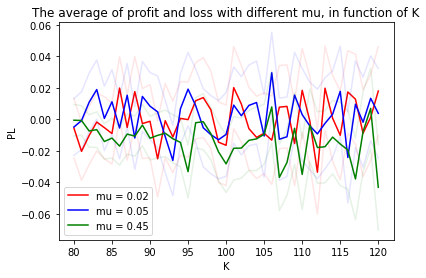

In [9]:
import matplotlib.pyplot as plt
axeX = np.arange(80, 121)
plt.plot(axeX, means[0.02], color="r", label="mu = 0.02")
plt.plot(axeX, means[0.02]-half_IC[0.02], color="r", alpha=0.1)
plt.plot(axeX, means[0.02]+half_IC[0.02], color="r", alpha=0.1)

plt.plot(axeX, means[0.05], color="b", label="mu = 0.05")
plt.plot(axeX, means[0.05]-half_IC[0.05], color="b", alpha=0.1)
plt.plot(axeX, means[0.05]+half_IC[0.05], color="b", alpha=0.1)

plt.plot(axeX, means[0.45], color="g", label="mu = 0.45")
plt.plot(axeX, means[0.45]-half_IC[0.45], color="g", alpha=0.1)
plt.plot(axeX, means[0.45]+half_IC[0.45], color="g", alpha=0.1)

plt.xlabel("K")
plt.ylabel("PL")
plt.title("The average of profit and loss with different mu, in function of K")

plt.legend()

We denote $\tilde{X_t} = e^{-rt}X_t$ and $\tilde{S_t} = e^{-rt}S_t$ the actualized value of $X_t$ and $S_t$. Then, we have :

$$
\tilde{X_T}(K) = BS(S_0, K, T) + \int_0^T \Delta_t(K) d\tilde{S_t}
$$
and with the derivative form :
$$
d\tilde{X_t} = e^{-rt}\theta_t\frac{d\tilde{S_t}}{\tilde{S_t}} = \Delta_t(K)d\tilde{S_t}\mbox{, with }\theta_t = S_t\Delta_t(K)
$$
Since $\Delta_t(K)$ is the optimal hedging strategy for the Black-Scholes model, we should have a expectation of 0 for the profit and loss. This is in fact an application of the propostion 6.14. with $g(S_T) = (S_T - K)^+$ and $X$ as the $X$ in this question.

We fix $\mu = 0.05, K = 100$. We are going to plot the corresponding graph in terms of the steps $n$.

In [10]:
means = []
half_IC = []
mu = 0.05
K = 100

for l in range(6, 13):
    n = 2 ** l
    PL = profit_loss(n, mu, K)
    means.append(np.mean(PL))
    half_IC.append(1.96 * np.sqrt(np.var(PL) / n))
means = np.array(means)
half_IC = np.array(half_IC)

Text(0.5, 1.0, 'The average of profit and loss with different mu, in function of n')

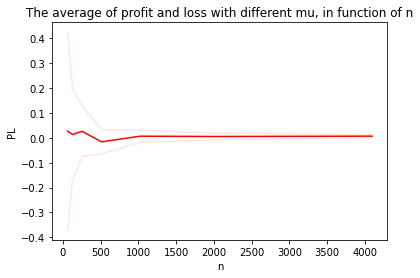

In [11]:
axeX = 2 ** np.arange(6, 13)
plt.plot(axeX, means, color="r")
plt.plot(axeX, means-half_IC, color="r", alpha=0.1)
plt.plot(axeX, means+half_IC, color="r", alpha=0.1)

plt.xlabel("n")
plt.ylabel("PL")
plt.title("The average of profit and loss with different mu, in function of n")

The number of steps $n$ doesn't have much influence on the result except for the error in variance.